In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset

import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [4]:
INPUT_PATH = "../../data/enron/enron_dataset_splitted_receivers.csv.gz"

Load the dataset

In [5]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')

Filter stuff if necessary

In [12]:
nodes_to_keep = range(dataset.dim)

#### Dataset exploration

Print statistics of the dataset

In [6]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 51,060
               %NZ: 21.77%

Stats. of num. of events per dim:
count     100.000000
mean      510.600000
std       524.892601
min         7.000000
25%       154.750000
50%       361.000000
75%       635.000000
max      3527.000000
dtype: float64


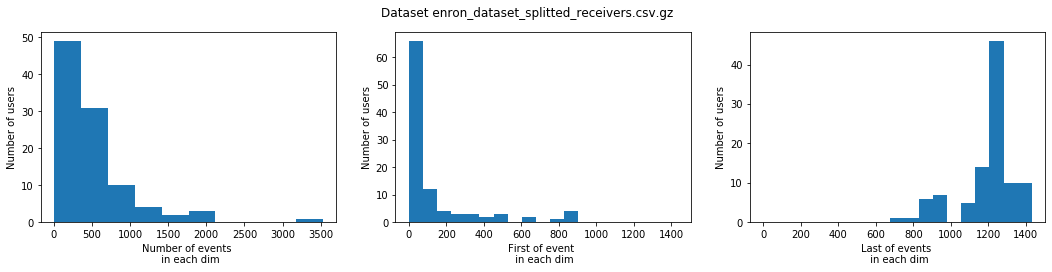

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')
axs[0].set_ylabel('Number of users')

end_time = max(map(max, dataset.timestamps))
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')
axs[1].set_ylabel('Number of users')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')
axs[2].set_ylabel('Number of users')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       2.431278
std        7.126163
min        0.065975
25%        0.294077
50%        1.051462
75%        1.662430
max       62.414747
dtype: float64
Median: 1.051461810185799


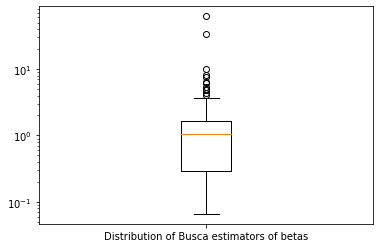

In [8]:
busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.boxplot(busca_betas, labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print('Median:', np.median(busca_betas))

Busca estimators of **beta_{ij}**:
count    10000.000000
mean         4.670327
std         13.699575
min          0.000000
25%          0.418984
50%          1.092299
75%          3.110960
max        223.170471
dtype: float64
Median: 1.0922993421554565


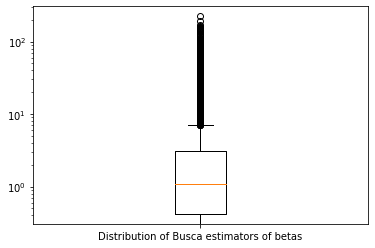

In [9]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model

plt.boxplot(busca_beta_ji.flatten(), labels=['Distribution of Busca estimators of betas']);
plt.yscale('log')
print('Busca estimators of **beta_{ij}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print('Median:', np.median(busca_beta_ji))

count    5.116000e+06
mean     2.072914e+01
std      5.271658e+01
min      0.000000e+00
25%      3.131714e-01
50%      2.718506e+00
75%      1.253845e+01
max      7.332789e+02
dtype: float64


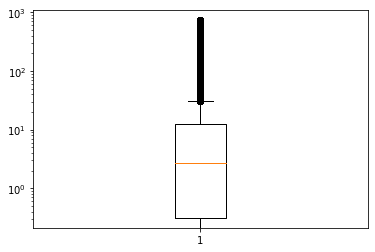

In [10]:
wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
all_delta_ikj = np.hstack([arr.flatten() for arr in wold_model.delta_ikj])

plt.boxplot(all_delta_ikj)
plt.yscale('log')
print(pd.Series(all_delta_ikj).describe())

#### Extract ground truth

Build ground truth adjacency matrix

In [13]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodes_to_keep).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

Set variables used for inferences

In [14]:
events = dataset.timestamps
end_time = dataset.timestamps

Set threshold for edge detection evaluation

In [15]:
THRESH = 0.01

---

## Run inference

---

### Run VI-fb

In [24]:
# Set model
vifb_model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)

#beta_vifb = dataset.busca_beta_ji
beta_vifb = 1.0 * np.ones_like(dataset.busca_beta_ji)

vifb_model.observe(events, beta=beta_vifb)

In [25]:
dim = len(events)

# Set priors
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

zc_pr = [1.0 * np.ones((len(ev), dim+1)) for ev in events]

beta = 1.0 * np.ones((dim, dim))
#beta = busca_beta_ji

In [27]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=THRESH, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
conv = vifb_model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=5000,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

iter:    10 | dx: +2.4583e+00 | f1-score: 0.25 | relerr: 2.68e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.57e-01     
iter:    20 | dx: +3.1755e-01 | f1-score: 0.16 | relerr: 2.70e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.36e-01     
iter:    30 | dx: +1.5121e-01 | f1-score: 0.12 | relerr: 2.70e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.35e-01     
iter:    40 | dx: +6.9963e-02 | f1-score: 0.10 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.25e-01     
iter:    50 | dx: +4.0486e-02 | f1-score: 0.09 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.23e-01     
iter:    60 | dx: +1.6861e-02 | f1-score: 0.08 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.19e-01     
iter:    70 | dx: +1.4341e-02 | f1-score: 0.08 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.18e-01     
iter:    80 | dx: +1.8486e-02 | f1-score: 0.08 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:   650 | dx: +2.3966e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.87e-01     
iter:   660 | dx: +1.1663e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.38e-01     
iter:   670 | dx: +1.8510e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.44e-01     
iter:   680 | dx: +6.5741e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.30e-01     
iter:   690 | dx: +9.0941e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.41e-01     
iter:   700 | dx: +1.5945e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.26e-01     
iter:   710 | dx: +1.8751e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.46e-01     
iter:   720 | dx: +1.0181e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  1290 | dx: +1.3589e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.17e-01     
iter:  1300 | dx: +1.3458e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.17e-01     
iter:  1310 | dx: +1.7349e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.17e-01     
iter:  1320 | dx: +1.4770e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.17e-01     
iter:  1330 | dx: +2.0594e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.17e-01     
iter:  1340 | dx: +2.7056e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.20e-01     
iter:  1350 | dx: +5.1530e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.30e-01     
iter:  1360 | dx: +6.9705e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  1930 | dx: +1.4773e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.38e-01     
iter:  1940 | dx: +1.3100e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.45e-01     
iter:  1950 | dx: +4.3888e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.28e-01     
iter:  1960 | dx: +1.5429e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.44e-01     
iter:  1970 | dx: +5.3285e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.31e-01     
iter:  1980 | dx: +1.2322e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.37e-01     
iter:  1990 | dx: +6.0655e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.27e-01     
iter:  2000 | dx: +6.8733e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  2570 | dx: +1.4542e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.25e-01     
iter:  2580 | dx: +1.3479e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.40e-01     
iter:  2590 | dx: +1.3554e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.33e-01     
iter:  2600 | dx: +9.8807e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.21e-01     
iter:  2610 | dx: +1.1016e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.27e-01     
iter:  2620 | dx: +1.3785e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.22e-01     
iter:  2630 | dx: +1.3287e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.21e-01     
iter:  2640 | dx: +9.8116e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  3210 | dx: +2.0472e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.27e-01     
iter:  3220 | dx: +1.5401e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.40e-01     
iter:  3230 | dx: +1.1203e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.42e-01     
iter:  3240 | dx: +1.0755e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.47e-01     
iter:  3250 | dx: +1.0921e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.37e-01     
iter:  3260 | dx: +1.4350e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.28e-01     
iter:  3270 | dx: +9.2738e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.22e-01     
iter:  3280 | dx: +1.4882e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  3850 | dx: +2.1386e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.79e-01     
iter:  3860 | dx: +1.4673e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.52e-01     
iter:  3870 | dx: +1.3073e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.46e-01     
iter:  3880 | dx: +1.0557e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.33e-01     
iter:  3890 | dx: +1.3202e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.33e-01     
iter:  3900 | dx: +1.1437e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.22e-01     
iter:  3910 | dx: +1.7785e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.62e-01     
iter:  3920 | dx: +1.4243e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

iter:  4490 | dx: +4.9923e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.20e-01     
iter:  4500 | dx: +1.9961e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.24e-01     
iter:  4510 | dx: +7.7080e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.44e-01     
iter:  4520 | dx: +1.6559e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.48e-01     
iter:  4530 | dx: +6.7150e-03 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.36e-01     
iter:  4540 | dx: +1.3707e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.35e-01     
iter:  4550 | dx: +1.4461e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.43e-01     
iter:  4560 | dx: +2.2282e-02 | f1-score: 0.07 | relerr: 2.69e+03 | p@5: 0.00 | p@10: 0.00 | p@20

In [89]:
adj_hat_mode = (vifb_model._as_po[1:, :] - 1) / vifb_model._ar_po[1:, :] 
adj_hat_mode[adj_hat_mode < 0] = 0

adj_hat_mean = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

adj_hat_std = np.sqrt(vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :] ** 2)

#adj_hat = adj_hat_mean / adj_hat_std
adj_hat = adj_hat_mean
#adj_hat = adj_hat_mode

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=THRESH)

Accuracy: 0.58

Edge counts
------------
Pred: 927.00
True: 1401.00

Error counts
------------
 True Positive: 187.00
False Positive: 740.00
 True Negative: 2483.00
False Negative: 1214.00

Error rates
-----------
 True Positive Rate: 0.13
False Positive Rate: 0.23
 True Negative Rate: 0.77
False Negative Rate: 0.87

F-Score
-------
 F1-Score: 0.16
Precision: 0.20
   Recall: 0.13

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.10000000000000005
10 0.16911764705882332
20 0.25588235294117634



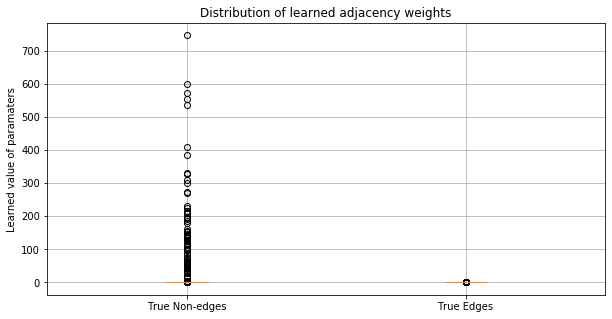

In [81]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adj_hat[adjacency_true == 0.0], 
        adj_hat[adjacency_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

In [82]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.201
Samples are correlated (reject H0) p=0.000


(array([  4.00,   9.00,  13.00,   8.00,   8.00,   4.00,   6.00,   9.00,   2.00,   5.00]),
 array([-0.46, -0.40, -0.34, -0.28, -0.22, -0.17, -0.11, -0.05,  0.01,  0.07,  0.13]),
 <a list of 10 Patch objects>)

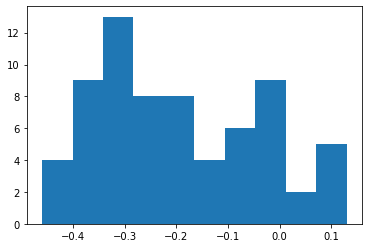

In [83]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

plt.hist(rank_corr_per_dim)

---

### Run VI

In [17]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [52]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(dataset.timestamps)

In [54]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

iter:     1 | dx: +9.7129e+00 | f1-score: 0.08 | relerr: 1.52e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 3.14e+01     
iter:     2 | dx: +9.7129e+00 | f1-score: 0.11 | relerr: 1.04e+02 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 1.03e+00     
iter:     3 | dx: +2.5630e+00 | f1-score: 0.12 | relerr: 9.46e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.90e-01     
iter:     4 | dx: +2.0666e+00 | f1-score: 0.14 | relerr: 9.18e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.71e-01     
iter:     5 | dx: +1.6923e+00 | f1-score: 0.15 | relerr: 9.11e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 8.78e-01     
iter:     6 | dx: +1.2975e+00 | f1-score: 0.16 | relerr: 9.11e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 9.05e-01     
iter:     7 | dx: +1.1342e+00 | f1-score: 0.17 | relerr: 9.13e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 9.06e-01     
iter:     8 | dx: +1.0267e+00 | f1-score: 0.18 | relerr: 9.16e+01 | p@5: 0.00 | p@10: 0.00 | p@20

iter:    65 | dx: +7.0643e-02 | f1-score: 0.17 | relerr: 8.36e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.44e+00     
iter:    66 | dx: +6.9339e-02 | f1-score: 0.17 | relerr: 8.36e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.21e+00     
iter:    67 | dx: +6.7989e-02 | f1-score: 0.17 | relerr: 8.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.12e+00     
iter:    68 | dx: +6.6553e-02 | f1-score: 0.17 | relerr: 8.35e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 8.64e-01     
iter:    69 | dx: +6.5170e-02 | f1-score: 0.17 | relerr: 8.34e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 7.88e-01     
iter:    70 | dx: +6.3926e-02 | f1-score: 0.17 | relerr: 8.34e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 7.95e-01     
iter:    71 | dx: +6.2510e-02 | f1-score: 0.17 | relerr: 8.33e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 7.96e-01     
iter:    72 | dx: +6.1210e-02 | f1-score: 0.17 | relerr: 8.33e+01 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   129 | dx: +1.1238e-02 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.13e-01     
iter:   130 | dx: +1.1265e-02 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 8.05e-01     
iter:   131 | dx: +1.0620e-02 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.05e+00     
iter:   132 | dx: +1.0553e-02 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 1.06e+00     
iter:   133 | dx: +1.0617e-02 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 9.99e-01     
iter:   134 | dx: +9.8202e-03 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 1.26e+00     
iter:   135 | dx: +9.8567e-03 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 9.72e-01     
iter:   136 | dx: +9.6205e-03 | f1-score: 0.16 | relerr: 8.21e+01 | p@5: 0.00 | p@10: 0.10 | p@20

KeyboardInterrupt: 

In [55]:
print('as nan:', np.isnan(vi_model._as_po).any())
print('ar nan:', np.isnan(vi_model._ar_po).any())
print('bs nan:', np.isnan(vi_model._bs_po).any())
print('br nan:', np.isnan(vi_model._br_po).any())
print('bs < 0:', np.any(vi_model._bs_po < 0))
print('br < 0:', np.any(vi_model._br_po < 0))
print('x0 < 0:', np.any(vi_model._b_x0 < 0))
print('xn < 0:', np.any(vi_model._b_xn < 0))
print('x0 inf:', np.any(vi_model._b_x0 > 1e10))
print('xn inf:', np.any(vi_model._b_xn > 1e10))

as nan: False
ar nan: False
bs nan: False
br nan: False
bs < 0: False
br < 0: False
x0 < 0: False
xn < 0: False
x0 inf: False
xn inf: False


In [56]:
zeros_indices = np.where(vi_model._b_xn > 1e10)
print(zeros_indices)
j = zeros_indices[0][0]
i = zeros_indices[1][0]
j, i

(array([], dtype=int64), array([], dtype=int64))


IndexError: index 0 is out of bounds for axis 0 with size 0

Extract variables where stuff went wrong

In [37]:
j = 88
i = 66
n = 0
bs_pr = vi_model._bs_pr
br_pr = vi_model._br_pr
as_po = vi_model._as_po
ar_po = vi_model._ar_po
zp_po = vi_model._zp_po
dts = vi_model.dt_ik
delta = vi_model.delta_ikj
valid_mask = vi_model.valid_mask_ikj

In [38]:
vi_model._b_x0[j,i], vi_model._b_xn[j,i]

(0.1, 0.1)

Vizualize the objective function and its derivatives

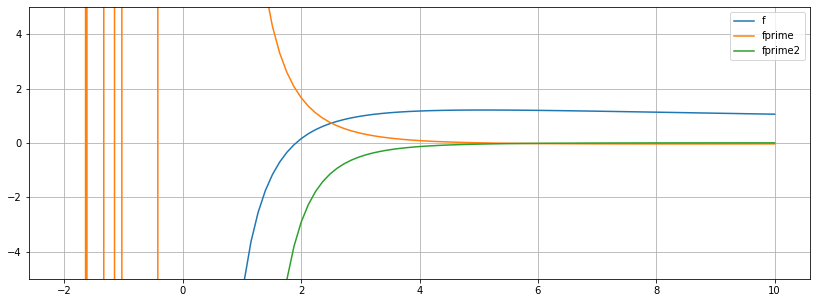

In [39]:
kwargs = {
    'j': j, 'i': i, 'n': n,
    'bs_pr': bs_pr, 'br_pr': br_pr, 
    'as_po': as_po, 'ar_po': ar_po,
    'zp_po': zp_po,
    'dts': dts, 'delta': delta, 'valid_mask': valid_mask,
}

x_range = np.linspace(-2.0, 10.0, 100)
func_range = np.zeros_like(x_range)
fprime_range = np.zeros_like(x_range)
fprime2_range = np.zeros_like(x_range)
for idx, xi in enumerate(x_range):
    func_range[idx], fprime_range[idx], fprime2_range[idx] = tsvar.models._wold_var._beta_funcs(x=xi, **kwargs)
    
plt.figure(figsize=(14, 5))
plt.plot(x_range, func_range, label='f')
plt.plot(x_range, fprime_range, label='fprime')
plt.plot(x_range, fprime2_range, label='fprime2')
plt.grid()
plt.ylim(-5.0, 5.0)
plt.legend();

In [48]:
from tsvar.models._wold_var import expect_alpha

x = 0.1

for it in range(10):
    print('it:', it)

    a_mean = expect_alpha(as_po[j+1, i], ar_po[j+1, i])
    x_p_delta = x + delta[i][:, j+1] + 1e-20

    term1 = (bs_pr[j, i] + 1 - n) / x
    term2 = br_pr[j, i] / (x ** 2)

    mask = valid_mask[i][:, j+1]
    term31 = zp_po[i][:, j+1] / x_p_delta
    term32 = a_mean * dts[i] / (x_p_delta ** 2)

    func = term1 - term2 + np.sum(mask * (term31 - term32))

    print('func =', term1, '-', term2, '+', np.sum(mask * (term31 - term32)), ' = ', func)

    term1 *= -1
    term1 /= x
    term2 *= -2
    term2 /= x
    term31 *= -1
    term31 /= x_p_delta
    term32 *= -2
    term32 /= x_p_delta

    fprime = term1 - term2 + np.sum(mask * (term31 - term32))

    print('fprime =', term1, '-', term2, '+', np.sum(mask * (term31 - term32)), ' = ', fprime)

    term1 *= -2
    term1 /= x
    term2 *= -3
    term2 /= x
    term31 *= -2
    term31 /= x_p_delta
    term32 *= -3
    term32 /= x_p_delta

    fprime2 = term1 - term2 + np.sum(mask * (term31 - term32))

    print('fprime2 =', term1, '-', term2, '+', np.sum(mask * (term31 - term32)), ' = ', fprime2)

    f = func
    fp = fprime
    fpp = fprime2

    x_new = x - (2 * f * fp) / (2 * fp**2 - f * fpp)
    print('x_new = ', x, '-', (2 * f * fp), '/', (2 * fp**2 - f * fpp), '=', x_new)

    print(f'x = {x:.5f} | x_new = {x_new:.5f} | diff = {abs(x - x_new):.1e}')

    x = x_new
    
    print('----')

it: 0
func = 110.0 - 999.9999999999998 + -73.3504376493323  =  -963.3504376493321
fprime = -1100.0 - -19999.999999999993 + 741.0777317786806  =  19641.077731778674
fprime2 = 22000.0 - 599999.9999999998 + -14656.864487668798  =  -592656.8644876686
x_new =  0.1 - -37842481.657627076 / 200607619.15146768 = 0.28863930401892823
x = 0.10000 | x_new = 0.28864 | diff = 1.9e-01
----
it: 1
func = 38.109847989650945 - 120.02979452845473 + -24.854499442009356  =  -106.77444598081314
fprime = -132.03277398130018 - -831.694040674263 + 88.55133488387841  =  788.2126015768412
fprime2 = 914.8634447416891 - 8644.290944725837 + -617.2301251082498  =  -8346.657625092397
x_new =  0.28863930401892823 - -168321.92769692524 / 351348.4668582941 = 0.7677133389849407
x = 0.28864 | x_new = 0.76771 | diff = 4.8e-01
----
it: 2
func = 14.32826478506162 - 16.966873698416276 + -8.90415653426423  =  -11.542765447618885
fprime = -18.663561068257902 - -44.201065259201116 + 12.636480991489337  =  38.17398518243255
fprime2

Print performance report

In [68]:
adj_hat_mode = (vi_model._as_po[1:, :] - 1) / vi_model._ar_po[1:, :] 
adj_hat_mode[adj_hat_mode < 0] = 0
adj_hat_mean = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
adj_hat_std = np.sqrt(vi_model._as_po[1:, :] / vi_model._ar_po[1:, :] ** 2)

beta_mean = vi_model._br_po / (vi_model._bs_po - 1)
beta_mode = vi_model._br_po / (vi_model._bs_po + 1)
beta_std = vi_model._br_po ** 2 / ((vi_model._bs_po - 1) ** 2 * (vi_model._bs_po - 2))

#adj_hat = adj_hat_mean / adj_hat_std
adj_hat = adj_hat_mean
#adj_hat = adj_hat_mode

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.001)

Accuracy: 0.69

Edge counts
------------
Pred: 1540.00
True: 2177.00

Error counts
------------
 True Positive: 306.00
False Positive: 1234.00
 True Negative: 6589.00
False Negative: 1871.00

Error rates
-----------
 True Positive Rate: 0.14
False Positive Rate: 0.16
 True Negative Rate: 0.84
False Negative Rate: 0.86

F-Score
-------
 F1-Score: 0.16
Precision: 0.20
   Recall: 0.14

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.10
Prec@20: 0.20

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.05400000000000002
10 0.10899999999999987
20 0.1895



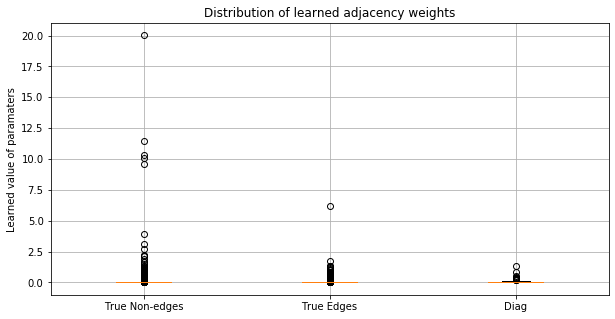

In [82]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0], adj_hat[np.eye(adj_hat.shape[0]).astype(bool)]],
    labels=['True Non-edges', 'True Edges', 'Diag'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

In [84]:
adjacency_true[np.eye(adj_hat.shape[0]).astype(bool)]

array([ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.03,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.02,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,
        0.01,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  1.00,  0.01,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.01,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.02,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.01,  0.01,  0.00])

In [85]:
top_edges = np.argsort(adj_hat.flatten())[::-1]
adjacency_true.flatten()[top_edges]

array([ 0.00,  0.00,  0.00, ...,  0.00,  0.00,  0.15])

---

### Run GB

In [90]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=300,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [91]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

#adj_hat = adj_hat / beta_hat  # Does not matter


experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.0)

Accuracy: 0.30

Edge counts
------------
Pred: 208.00
True: 1401.00

Error counts
------------
 True Positive: 87.00
False Positive: 121.00
 True Negative: 3102.00
False Negative: 1314.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.04
 True Negative Rate: 0.96
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.11
Precision: 0.42
   Recall: 0.06

Precision@k
-----------
 Prec@5: 0.60
Prec@10: 0.80
Prec@20: 0.70

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.1705882352941176
10 0.16029411764705878
20 0.12573529411764706



In [171]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=0.03204881895953531, pvalue=0.0007088376296667749)

In [172]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

0.05585231454261796

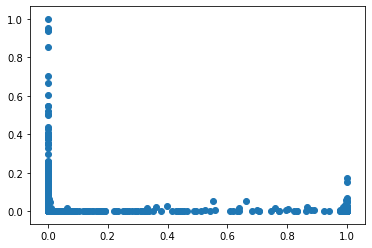

In [173]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [174]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [175]:
mean_rank_corr

0.05585231454261796

(array([  6.00,  31.00,  10.00,  13.00,  18.00,  14.00,   1.00,   2.00,   2.00,   2.00]),
 array([-0.16, -0.10, -0.03,  0.03,  0.10,  0.16,  0.22,  0.29,  0.35,  0.42,  0.48]),
 <a list of 10 Patch objects>)

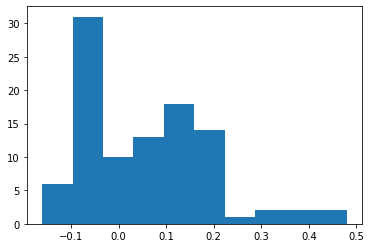

In [176]:
plt.hist(rank_corr_per_dim)

In [177]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: 0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

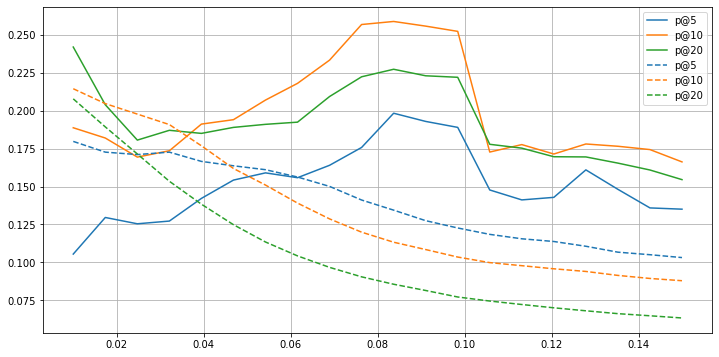

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();